# Analyzing the Execution Times


In [3]:
import pandas as pd

# Load execution times data into DataFrame
execution_times_path = "/Users/stalaei/Desktop/Text2SQL/Optimize-SQL/data/Execution times of bird queries - query_exec_times.csv"
execution_times_df = pd.read_csv(execution_times_path)

execution_times_df.columns

Index(['db_id', 'query', 'question_id', 'question', 'evidence',
       'average_exec_time', 'max_exec_time', 'min_exec_time', 'std_exec_time',
       'sample_executions'],
      dtype='object')

In [4]:
# Get top slowest queries by average execution time
top_slowest = execution_times_df.nlargest(30, 'average_exec_time')[['db_id', 'question_id', 'average_exec_time']]

print("Top slowest queries by average execution time:")
print(top_slowest.to_string())


Top slowest queries by average execution time:
                   db_id  question_id  average_exec_time
596   codebase_community          596           7.681081
646   codebase_community          646           4.822105
1014           formula_1         1014           1.823459
1015           formula_1         1015           1.424290
1016           formula_1         1016           1.418717
384           card_games          384           0.830425
108            financial          108           0.802061
116            financial          116           0.776388
145            financial          145           0.660296
106            financial          106           0.637683
1011           formula_1         1011           0.575801
179            financial          179           0.569114
640   codebase_community          640           0.566210
520           card_games          520           0.557372
595   codebase_community          595           0.511516
1006           formula_1         1006    

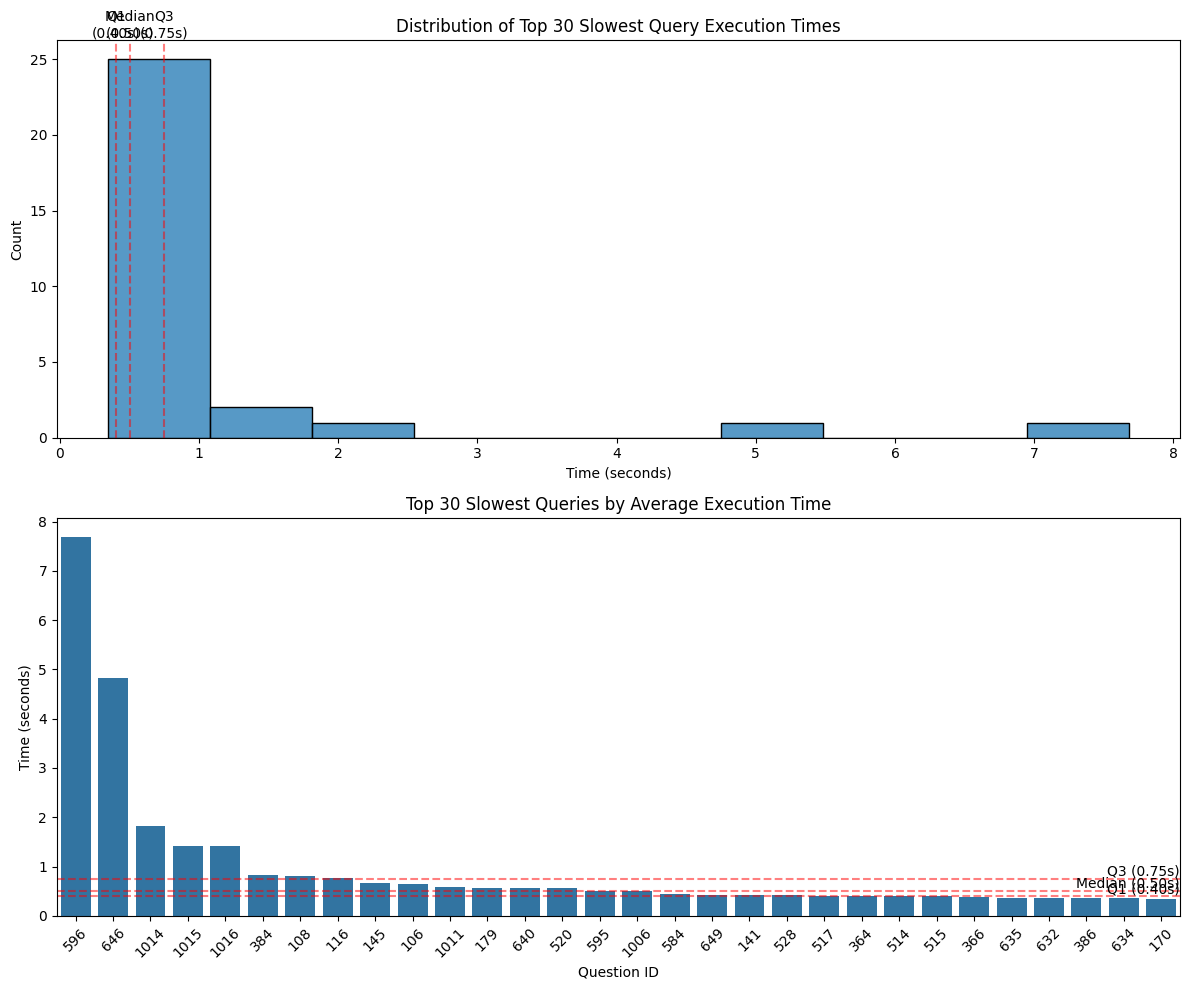


Summary Statistics for Top 30 Slowest Queries:
count    30.000000
mean      0.986959
std       1.521182
min       0.345541
25%       0.401654
50%       0.503631
75%       0.747365
max       7.681081
Name: average_exec_time, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get top 30 slowest queries
top_slowest = execution_times_df.nlargest(30, 'average_exec_time')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histogram of top slowest queries
sns.histplot(data=top_slowest['average_exec_time'], bins=10, ax=ax1)
quantiles = np.percentile(top_slowest['average_exec_time'], [25, 50, 75])
for q, label in zip(quantiles, ['Q1', 'Median', 'Q3']):
    ax1.axvline(q, color='r', linestyle='--', alpha=0.5)
    ax1.text(q, ax1.get_ylim()[1], f'{label}\n({q:.2f}s)', 
             rotation=0, ha='center', va='bottom')
ax1.set_title('Distribution of Top 30 Slowest Query Execution Times')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Count')

# Bar plot of top slowest queries sorted by execution time
sorted_data = top_slowest.sort_values('average_exec_time', ascending=False)
# Create ordered categorical type for question_id based on sorted order
sorted_data['question_id'] = pd.Categorical(sorted_data['question_id'], 
                                          categories=sorted_data['question_id'].values,
                                          ordered=True)
sns.barplot(data=sorted_data, y='average_exec_time', x='question_id', ax=ax2)
for q, label in zip(quantiles, ['Q1', 'Median', 'Q3']):
    ax2.axhline(q, color='r', linestyle='--', alpha=0.5)
    ax2.text(ax2.get_xlim()[1], q, f'{label} ({q:.2f}s)', 
             rotation=0, ha='right', va='bottom')
ax2.set_title('Top 30 Slowest Queries by Average Execution Time')
ax2.set_xlabel('Question ID')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for top slowest queries
print("\nSummary Statistics for Top 30 Slowest Queries:")
print(top_slowest['average_exec_time'].describe())


# Optimize Query Tree Search

In [6]:
import sys
sys.path.append('/Users/stalaei/Desktop/Text2SQL/Optimize-SQL/src')

## Setting up the connection with the database

In [7]:
from database_utils.database_manager import DatabaseManager
import time

# Get a sample row with question_id 1015
sample_query = top_slowest[top_slowest['question_id'] == 1015].iloc[0]
print("\nSample Query Details:")
print(f"Question: {sample_query['question']}")
print(f"Query: {sample_query['query']}")
print(f"Evidence: {sample_query['evidence']}")
print(f"Average Execution Time: {sample_query['average_exec_time']:.2f} seconds")


db_manager = DatabaseManager(db_mode="dev", db_id=sample_query['db_id'])


import numpy as np
from tqdm import tqdm

times = []
for _ in tqdm(range(10)):
    result, execution_time = db_manager.execute_sql(sample_query['query'], report_time=True)
    times.append(execution_time)

avg_time = np.mean(times)
std_time = np.std(times)
print(f"\nAverage execution time: {avg_time:.4f} seconds")
print(f"Standard deviation: {std_time:.4f} seconds") 
print(f"Result: {result}")


Sample Query Details:
Question: In which Formula_1 race was the lap record for the Austrian Grand Prix Circuit set?
Query: WITH fastest_lap_times AS ( SELECT T1.raceId, T1.FastestLapTime, (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) as time_in_seconds FROM results AS T1 WHERE T1.FastestLapTime IS NOT NULL ) SELECT T2.name FROM races AS T2 INNER JOIN circuits AS T3 on T2.circuitId = T3.circuitId INNER JOIN results AS T1 on T2.raceId = T1.raceId INNER JOIN ( SELECT MIN(fastest_lap_times.time_in_seconds) as min_time_in_seconds FROM fastest_lap_times INNER JOIN races AS T2 on fastest_lap_times.raceId = T2.raceId INNER JOIN circuits AS T3 on T2.circuitId = T3.circuitId WHERE T2.name = 'Austrian Grand Prix') AS T4 ON (CAST(

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Average execution time: 0.6525 seconds
Standard deviation: 0.0048 seconds
Result: [('Austrian Grand Prix',)]


In [8]:
db_schema = db_manager.get_db_schema()
db_schema_string = db_manager.get_database_schema_string(tentative_schema=db_schema, schema_with_examples=None, schema_with_descriptions=None, include_value_description=True)
print(db_schema_string)

CREATE TABLE constructors
(
	constructorId INTEGER primary key autoincrement,
	nationality TEXT, -- Example Values: `('British',)`, `('German',)`, `('French',)` | Value Statics: Total count 208 - Distinct count 24 - Null count 0   
	name TEXT default '' not null unique, -- Example Values: `('AFM',)`, `('AGS',)`, `('ATS',)` | Value Statics: Total count 208 - Distinct count 208 - Null count 0   
	url TEXT default '' not null, -- Example Values: `('http://en.wikipedia.org/wiki/McLaren',)`, `('http://en.wikipedia.org/wiki/BMW_Sauber',)`, `('http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering',)` | Value Statics: Total count 208 - Distinct count 171 - Null count 0   
	constructorRef TEXT default '' not null, -- Example Values: `('mclaren',)`, `('bmw_sauber',)`, `('williams',)` | Value Statics: Total count 208 - Distinct count 208 - Null count 0   
);

CREATE TABLE constructorResults
(
	foreign key (constructorId) references constructors(constructorId),
	foreign key (raceId) referen

## Testing the LLM client

In [9]:
from llm_client.llm_client import GeminiClient, LLMClient

llm_client = GeminiClient()
result = llm_client.call_llm(prompt="What is the capital of France?", model="gemini-2.5-flash-preview-05-20", batch_size=5, temperature=0.3, max_candidates=8, output_format="text")
print(result)


['The capital of France is **Paris**.', 'The capital of France is **Paris**.', 'The capital of France is **Paris**.', 'The capital of France is **Paris**.', 'The capital of France is **Paris**.']


In [10]:
QUERY_OPTIMIZATION_PROMPT = """
You are a SQL query optimizer.
You are given a query and a database.
You need to optimize the query to be more efficient, while keeping the execution result the same.

## Database Schema
{db_schema}

## Question
{question}

## Evidence
{evidence}

## Optimization History
{optimization_history}

Now, it's your turn to optimize the query, while keeping the execution result the same.
First, think and ideate about a plan for optimizing the query, and then implement it.

You should output your response in the following JSON format:
{{
    "idea": "your idea for optimizing the query",
    "query": "the optimized query"
}}
"""

In [11]:
optimization_history = f"""
Idea: This is the initial query.
Query: {sample_query['query']}
Average execution time: {sample_query['average_exec_time']:.2f} seconds
"""

prompt = QUERY_OPTIMIZATION_PROMPT.format(db_schema=db_schema_string, question=sample_query['question'], evidence=sample_query['evidence'], optimization_history=optimization_history)
print(prompt)


You are a SQL query optimizer.
You are given a query and a database.
You need to optimize the query to be more efficient, while keeping the execution result the same.

## Database Schema
CREATE TABLE constructors
(
	constructorId INTEGER primary key autoincrement,
	nationality TEXT, -- Example Values: `('British',)`, `('German',)`, `('French',)` | Value Statics: Total count 208 - Distinct count 24 - Null count 0   
	name TEXT default '' not null unique, -- Example Values: `('AFM',)`, `('AGS',)`, `('ATS',)` | Value Statics: Total count 208 - Distinct count 208 - Null count 0   
	url TEXT default '' not null, -- Example Values: `('http://en.wikipedia.org/wiki/McLaren',)`, `('http://en.wikipedia.org/wiki/BMW_Sauber',)`, `('http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering',)` | Value Statics: Total count 208 - Distinct count 171 - Null count 0   
	constructorRef TEXT default '' not null, -- Example Values: `('mclaren',)`, `('bmw_sauber',)`, `('williams',)` | Value Statics: Tot

In [12]:
results = llm_client.call_llm(prompt=prompt, model="gemini-2.5-flash-preview-05-20", batch_size=5, temperature=0.3, max_candidates=8, output_format="json")
print(results)

['{\n  "idea": "The original query is overly complex. It uses a CTE to calculate `time_in_seconds`, then a subquery to find the minimum of these times, and finally joins back to the `results` table, re-calculating the `time_in_seconds` expression in the join condition. It also includes an unnecessary join to the `circuits` table as the filtering is done on `races.name`.\\n\\nMy optimization strategy is as follows:\\n1.  **Simplify Time Conversion**: Instead of using a CTE and re-calculating the `FastestLapTime` to seconds multiple times, perform this conversion directly within the `ORDER BY` clause.\\n2.  **Use `ORDER BY` and `LIMIT 1`**: To find the race with the minimum fastest lap time, we can directly order the relevant results by the calculated time in ascending order and then use `LIMIT 1` to retrieve only the top row. This eliminates the need for the CTE and the nested subquery that finds the minimum time.\\n3.  **Remove Redundant Joins**: The `circuits` table is joined in the o

In [13]:
results

['{\n  "idea": "The original query is overly complex. It uses a CTE to calculate `time_in_seconds`, then a subquery to find the minimum of these times, and finally joins back to the `results` table, re-calculating the `time_in_seconds` expression in the join condition. It also includes an unnecessary join to the `circuits` table as the filtering is done on `races.name`.\\n\\nMy optimization strategy is as follows:\\n1.  **Simplify Time Conversion**: Instead of using a CTE and re-calculating the `FastestLapTime` to seconds multiple times, perform this conversion directly within the `ORDER BY` clause.\\n2.  **Use `ORDER BY` and `LIMIT 1`**: To find the race with the minimum fastest lap time, we can directly order the relevant results by the calculated time in ascending order and then use `LIMIT 1` to retrieve only the top row. This eliminates the need for the CTE and the nested subquery that finds the minimum time.\\n3.  **Remove Redundant Joins**: The `circuits` table is joined in the o

In [17]:
import json

parsed_results = [json.loads(response) for response in results]
# print(parsed_results[0])
# parsed_result = parse_json_response(results[0])
print(f"Idea:\n{parsed_results[0]['idea']}\n\n")
print(f"Query:\n{parsed_results[0]['query']}\n\n")


Idea:
The original query is overly complex. It uses a CTE to calculate `time_in_seconds`, then a subquery to find the minimum of these times, and finally joins back to the `results` table, re-calculating the `time_in_seconds` expression in the join condition. It also includes an unnecessary join to the `circuits` table as the filtering is done on `races.name`.

My optimization strategy is as follows:
1.  **Simplify Time Conversion**: Instead of using a CTE and re-calculating the `FastestLapTime` to seconds multiple times, perform this conversion directly within the `ORDER BY` clause.
2.  **Use `ORDER BY` and `LIMIT 1`**: To find the race with the minimum fastest lap time, we can directly order the relevant results by the calculated time in ascending order and then use `LIMIT 1` to retrieve only the top row. This eliminates the need for the CTE and the nested subquery that finds the minimum time.
3.  **Remove Redundant Joins**: The `circuits` table is joined in the original query but is

In [22]:
# Run each proposed query multiple times and collect statistics
for i, parsed_result in enumerate(parsed_results):
    print(f"\nTesting Query {i+1}:")
    print("-" * 40)
    print(f"Query: {parsed_result['query']}\n")
    
    times = []
    for _ in tqdm(range(10)):
        result, execution_time = db_manager.execute_sql(parsed_result['query'], report_time=True)
        times.append(execution_time)

    avg_time = np.mean(times)
    std_time = np.std(times)
    print(f"\nAverage execution time: {avg_time:.4f} seconds")
    print(f"Standard deviation: {std_time:.4f} seconds")
    print(f"Result: {result}")


Testing Query 1:
----------------------------------------
Query: SELECT T2.name FROM races AS T2 INNER JOIN results AS T1 ON T2.raceId = T1.raceId WHERE T2.name = 'Austrian Grand Prix' AND T1.FastestLapTime IS NOT NULL ORDER BY (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) LIMIT 1



100%|██████████| 10/10 [00:00<00:00, 311.73it/s]



Average execution time: 0.0025 seconds
Standard deviation: 0.0019 seconds
Result: [('Austrian Grand Prix',)]

Testing Query 2:
----------------------------------------
Query: WITH circuit_info AS (
    SELECT circuitId
    FROM circuits
    WHERE name = 'Austrian Grand Prix'
),
fastest_lap_times_converted AS (
    SELECT
        T1.raceId,
        (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) +
        (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) +
        (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) AS time_in_seconds
    FROM results AS T1
    WHERE T1.FastestLapTime IS NOT NULL
),
min_time_for_circuit AS (
    SELECT MIN(flt.time_in_seconds) AS min_seconds
    FROM fastest_lap_times_converted AS flt
    INNER JOIN races AS r ON flt.raceId = r.raceId
    INNER JOIN circuit_info AS ci ON r.circuitId = ci.circu

100%|██████████| 10/10 [00:00<00:00, 242.01it/s]



Average execution time: 0.0021 seconds
Standard deviation: 0.0012 seconds
Result: []

Testing Query 3:
----------------------------------------
Query: SELECT T2.name FROM results AS T1 INNER JOIN races AS T2 ON T1.raceId = T2.raceId WHERE T2.name = 'Austrian Grand Prix' AND T1.FastestLapTime IS NOT NULL ORDER BY (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) LIMIT 1



100%|██████████| 10/10 [00:00<00:00, 714.03it/s]



Average execution time: 0.0012 seconds
Standard deviation: 0.0001 seconds
Result: [('Austrian Grand Prix',)]

Testing Query 4:
----------------------------------------
Query: SELECT T2.name FROM results AS T1 INNER JOIN races AS T2 ON T1.raceId = T2.raceId INNER JOIN circuits AS T3 ON T2.circuitId = T3.circuitId WHERE T3.name = 'Austrian Grand Prix' AND T1.FastestLapTime IS NOT NULL ORDER BY (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) LIMIT 1



100%|██████████| 10/10 [00:00<00:00, 612.47it/s]



Average execution time: 0.0014 seconds
Standard deviation: 0.0002 seconds
Result: []

Testing Query 5:
----------------------------------------
Query: SELECT T2.name FROM results AS T1 JOIN races AS T2 ON T1.raceId = T2.raceId WHERE T2.name = 'Austrian Grand Prix' AND T1.FastestLapTime IS NOT NULL ORDER BY (CAST(SUBSTR(T1.FastestLapTime, 1, INSTR(T1.FastestLapTime, ':') - 1) AS REAL) * 60) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, ':') + 1, INSTR(T1.FastestLapTime, '.') - INSTR(T1.FastestLapTime, ':') - 1) AS REAL)) + (CAST(SUBSTR(T1.FastestLapTime, INSTR(T1.FastestLapTime, '.') + 1) AS REAL) / 1000) LIMIT 1



100%|██████████| 10/10 [00:00<00:00, 646.91it/s]


Average execution time: 0.0013 seconds
Standard deviation: 0.0002 seconds
Result: [('Austrian Grand Prix',)]


# Optimize Query Tree Search

In [24]:
from typing import Optional, List, Any

class QueryNode:
    def __init__(self, idea: str, query: str, db_id: str = None, parent: Optional['QueryNode'] = None):
        self.idea = idea
        self.query = query
        self.parent = parent
        self.children = []
        if parent:
            parent.children.append(self)
            self.id = f"{parent.id}.{len(parent.children)}"
            self.db_id = parent.db_id
            self.status = "unchecked"
        else:
            assert db_id is not None, "db_id must be provided for the root node"
            self.db_id = db_id
            self.status = "correct"
            self.id = "root"
        
        self.result = None
        self.run_times = []
        self.run_time_mean = float('inf')
        self.run_time_std = float('inf')
    
    def get_subtree(self, 
                    validation_status: str # "correct" | "incorrect" | "unchecked" | "error"
                    ) -> List['QueryNode']:
        nodes = []
        if self.status == validation_status:
            nodes.append(self)
        for child in self.children:
            nodes.extend(child.get_subtree(validation_status))
        return nodes
    
    def __repr__(self):
        return (
            f"QueryNode(\n"
            f"    id={self.id},\n"
            f"    idea={self.idea},\n" 
            f"    query={self.query},\n"
            f"    db_id={self.db_id},\n"
            f"    valid={self.valid},\n"
            f"    run_time_mean={self.run_time_mean}\n"
            f"    run_time_std={self.run_time_std}\n"
            f"    N={len(self.run_times)}\n"
            f")"
        )
    

In [30]:
from concurrent.futures import ThreadPoolExecutor, as_completed

class OptimizeQueryTreeSearch:
    
    def __init__(self, task_data: dict, llm_client: LLMClient, client_kwargs: dict, branch_count: int, top_k: int, max_depth: int):
        self.db_id = task_data['db_id']
        self.db_manager = DatabaseManager(db_mode=task_data['db_mode'], db_id=self.db_id)
        
        self.question_id = task_data['question_id']
        self.question = task_data['question']
        self.evidence = task_data['evidence']
        
        self.root_query_node = QueryNode(idea="This is the initial query.", 
                                         query=task_data['SQL'],
                                         db_id=self.db_id,
                                         parent=None)
        self.measure_run_time(self.root_query_node)
        try:
            self.execute_query(self.root_query_node, store_result=True)
        except Exception as e:
            raise f"The initial query is erroneous: {e}"
        
        self.llm_client = llm_client
        self.client_kwargs = client_kwargs
        
        self.branch_count = branch_count
        self.top_k = top_k
        self.max_depth = max_depth
        
    def get_top_k_queries(self, k: int) -> list:
        correct_nodes = self.root_query_node.get_subtree(validation_status="correct")
        correct_nodes = sorted(correct_nodes, key=lambda x: x.run_time_mean)
        return correct_nodes[:k]
       
    def expand_node(self, node: QueryNode) -> List['QueryNode']:
        
        def get_optimization_history(node: QueryNode) -> str:
            path = []
            current_node = node
            while current_node:
                path.append(current_node)
                current_node = current_node.parent
            path.reverse()
            optimization_history = "---\n"
            for i, node in enumerate(path):
                optimization_history += f"Step {i+1}:\n"
                optimization_history += f"Idea: {node.idea}\n"
                optimization_history += f"Query: {node.query}\n"
                optimization_history += f"Average execution time: {node.run_time_mean:.2f} seconds\n"
                optimization_history += f"Standard deviation: {node.run_time_std:.2f} seconds\n"
                optimization_history += f"Number of runs: {len(node.run_times)}\n"
                optimization_history += f"---\n"
            return optimization_history
        
        tentative_schema = self.db_manager.get_db_schema()
        schema_string = self.db_manager.get_database_schema_string(tentative_schema=tentative_schema, 
                                                                   schema_with_examples=None, 
                                                                   schema_with_descriptions=None, 
                                                                   include_value_description=True)
        
        prompt = QUERY_OPTIMIZATION_PROMPT.format(db_schema=schema_string, 
                                                  question=self.question, 
                                                  evidence=self.evidence, 
                                                  optimization_history=get_optimization_history(node))
        
        results = self.llm_client.call_llm(prompt=prompt, 
                                           model=self.client_kwargs['model'], 
                                           batch_size=self.branch_count,
                                           temperature=self.client_kwargs['temperature'], 
                                           max_candidates=self.client_kwargs['max_candidates'], 
                                           output_format="json")
        parsed_results = []
        for i, result in enumerate(results):
            try:
                parsed_result = json.loads(result)
                parsed_results.append(parsed_result)
            except Exception as e:
                print(f"Error parsing result {i}: {e}")
        
        new_nodes = []
        for parsed_result in parsed_results:
            new_node = QueryNode(idea=parsed_result['idea'], 
                                 query=parsed_result['query'], 
                                 db_id=self.db_id, 
                                 parent=node)
            new_nodes.append(new_node)
        
        return new_nodes
        
    def expand_nodes(self, nodes: List['QueryNode']) -> List['QueryNode']:
        expanded_nodes = []
        with ThreadPoolExecutor() as executor:
            # Map each node to a future that will expand it
            future_to_node = {
                executor.submit(self.expand_node, node): node 
                for node in nodes
            }
            
            # Collect results in order as they complete
            for future in as_completed(future_to_node):
                original_node = future_to_node[future]
                try:
                    # Get the expanded nodes for this node
                    new_nodes = future.result()
                    expanded_nodes.extend(new_nodes)
                except Exception as e:
                    print(f"Error expanding node: {e}")
                    
        return expanded_nodes
    
    def execute_query(self, query_node: QueryNode, store_result: bool = False) -> List[Any]:
        try:
            result = self.db_manager.execute_sql(query_node.query)
            if store_result:
                query_node.result = result
            return result
        except Exception as e:
            raise e
        
    def evaluate_node(self, query_node: QueryNode) -> bool:
        try:
            result = self.execute_query(query_node, store_result=True)
            if set(self.root_query_node.result) == set(result):
                query_node.status = "correct"
                return True
            else:
                query_node.status = "incorrect"
                return False    
        except Exception as e:
            query_node.status = f"error"
            return False
    
    def evaluate_nodes(self, nodes: List['QueryNode']) -> List['QueryNode']:
        correct_nodes = []
        with ThreadPoolExecutor() as executor:
            future_to_node = {
                executor.submit(self.evaluate_node, node): node 
                for node in nodes
            }
    
            for future in as_completed(future_to_node):
                original_node = future_to_node[future]
                try:
                    result = future.result()
                    if result:
                        correct_nodes.append(original_node)
                except Exception as e:
                    print(f"Error evaluating node: {e}")
        return correct_nodes
    
    def measure_run_time(self, node: QueryNode, trials: int = 10):
        times = []
        for _ in range(trials):
            try:
                _, execution_time = self.db_manager.execute_sql(node.query, report_time=True)
                times.append(execution_time)
            except Exception as e:
                pass
        node.run_time_mean = np.mean(times)
        node.run_time_std = np.std(times)
        node.run_times = times
        return node
    
    def measure_run_times(self, nodes: List['QueryNode']):
        for node in nodes:
            self.measure_run_time(node)
        
    def optimize_query(self) -> str:
        for depth in range(1, self.max_depth + 1):
            print(f"Depth {depth} of {self.max_depth}")
            top_k_nodes = self.get_top_k_queries(self.top_k)
            print(f"Queries to expand: {len(top_k_nodes)}")
            generated_nodes = self.expand_nodes(top_k_nodes)
            print(f"Generated nodes: {len(generated_nodes)}")
            correct_nodes = self.evaluate_nodes(generated_nodes)
            print(f"Correct nodes: {len(correct_nodes)}")
            self.measure_run_times(correct_nodes)


In [31]:
sample_query = top_slowest[top_slowest['question_id'] == 1015].iloc[0]

task_data = {
    "db_id": sample_query['db_id'],
    "db_mode": "dev",
    "question_id": sample_query['question_id'],
    "question": sample_query['question'],
    "evidence": sample_query['evidence'],
    "SQL": sample_query['query']
}

client_kwargs = {
    "model": "gemini-2.5-flash-preview-05-20",
    "temperature": 0.3,
    "max_candidates": 8,
    "output_format": "json"
}

branch_count = 1
top_k = 1
max_depth = 1

optimizer = OptimizeQueryTreeSearch(task_data=task_data, llm_client=llm_client, client_kwargs=client_kwargs, branch_count=branch_count, top_k=top_k, max_depth=max_depth)


In [32]:
optimizer.optimize_query()

Depth 1 of 1
Queries to expand: 1
Generated nodes: 1
Correct nodes: 1


In [33]:
optimizer.root_query_node.run_time_mean

np.float64(0.6412735939025879)

In [34]:
optimizer.root_query_node.children[0].run_time_mean

np.float64(0.002375030517578125)